# **Movie genre classifier**
The following script uses description of a movie to predict the genre of the movie. It preprocess the given description, builds an ML model over the data and then pickle the best model.

---

To run this script, following libraries must be installed:


*   nltk: for natural language processing
*   numpy: for handaling arrays
*   pandas: to load and handle datasets
*   matplotlib: for plotting purposes
*   seaborn: for advance plots
*   re: for handling regex
*   sklearn: for basic machine learning tools
*   pickle: for storing and loading models

## Download essensitals
Import `nltk` and download `stopwords` and `punkt` for using stop words.

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import required libraries
Following cell imports all the required libraries, classes and functions.

> Make sure all the prementioned liraries are installed.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import pickle

## Load train data
Following cell loads the training data from GitHub. The loaded data contains 4 columns which are,
- `id`: index of movie starting from 1
- `title`: title of the movie
- `genre`: movies's genre which is out target
- `description`: movie's description which will be used as feature

<!---->
Id column is not required, thus it is removed.

In [3]:
train_data_url = 'https://raw.githubusercontent.com/PyGamer-001/Encryptix/main/Datasets/Genre%20Classification%20Dataset/train_data.txt'
train_movie_data = pd.read_csv(train_data_url, header=None, sep=':::', engine='python')
header = ['id', 'title', 'genre', 'description']
train_movie_data.columns = header
train_movie_data.drop(columns='id', inplace=True)
print(train_movie_data.head())
train_movie_data.describe()

                                title       genre  \
0       Oscar et la dame rose (2009)       drama    
1                       Cupid (1997)    thriller    
2   Young, Wild and Wonderful (1980)       adult    
3              The Secret Sin (1915)       drama    
4             The Unrecovered (2007)       drama    

                                         description  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  


,title,genre,description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


## Identifying duplicated
The data may have duplicated values, thus the following cell shows details about such values. Duplicates are identified on basis of duplicated description.

In [4]:
train_movie_data.loc[train_movie_data.duplicated(subset='description', keep=False), 'description'].value_counts()

description
 Grammy - music award of the American academy of the audio recording, was founded by the American association of sound-recording companies of March, 14, 1958. Grammy is awarded annually as a result of voting by the authorized members of "Recording Academy".                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Drop duplicates
This cell drops non-first occurances of duplicated values.

In [5]:
train_movie_data.drop_duplicates(subset='description', inplace=True)
train_movie_data.loc[train_movie_data.duplicated(subset='description', keep=False), 'description'].value_counts()

Series([], Name: count, dtype: int64)

## Seprate features and target
This cell seprates features from target by storing features into `X_full` and targets in `y_full`.

In [6]:
X_full = train_movie_data.drop(columns=['title', 'genre'])
y_full = train_movie_data['genre']
print(X_full.head())
y_full.head()

                                         description
0   Listening in to a conversation between his do...
1   A brother and sister with a past incestuous r...
2   As the bus empties the students for their fie...
3   To help their unemployed father make ends mee...
4   The film's title refers not only to the un-re...


0        drama 
1     thriller 
2        adult 
3        drama 
4        drama 
Name: genre, dtype: object

##  Clean description
Following cell creates a function which cleans the the text provided to it. The function `clean_text` takes a text as input and performs the following cleaning operations.
- Convert all character to lowercase
- Remove links
- Remove emails
- Remove mentions
- Remove non-alphabetic characters
- Replace multiple spaces with a single space
- Remove stopwords from text

In [7]:
def clean_text(text: str):
    """
    Clean the text
    Args:
      text: string to be cleaned
    Returns:
      cleaned text
    """
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+',"",text)
    text = re.sub(r'@\S+','',text)
    text = re.sub('[^a-z+]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n', ' ', text)
    token = text.split()
    text = ' '.join([word for word in token if word not in stopwords.words('english')])
    return text


### Apply cleaning function
This cell applies the above function to each description.

> **Note**: This cell takes over 9 minutes to fully execute, thus its suggested to directly load the cleaned description file without running this code cell.

In [8]:
# X_full['description'] = X_full['description'].apply(clean_text)
# X_full.to_csv('clean_data.csv')
# X_full

## Load cleaned data
This cell loads the cleaned data directly from GitHub. Run the following cell to save time.

In [9]:
X_full = pd.read_csv('https://raw.githubusercontent.com/PyGamer-001/Encryptix_1/main/Movie%20Genre%20Classifier/clean_train_data.csv', index_col=0)
X_full

,description
0,listening conversation doctor parents year old...
1,brother sister past incestuous relationship cu...
2,bus empties students field trip museum natural...
3,help unemployed father make ends meet edith tw...
4,film title refers un recovered bodies ground z...
...,...
54209,short lived nbc live sitcom centered bonino wo...
54210,next generation exploitation sisters kapa bay ...
54211,ze bestaan echt stand comedy growing facing fe...
54212,walter vivian live country difficult time keep...


## Split data
This cell splits data into training and validation sets. The split is 90/10 .

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.1, random_state=3)
X_train, X_val,y_train, y_val

(                                             description
 43932  islamic revolution iran brought twenty five hu...
 29122  deception dallas follows trail intrigue decept...
 41318  experienced perhaps greatest crimes humanity w...
 38106  maheen sana askari faces many challenges life ...
 45113  film made italian television series eight epis...
 ...                                                  ...
 25587  small rural town live akheela family consistin...
 48157  end anton krastev dop wife diana separated iro...
 11520  married couple seeking break hectic lives esca...
 1688   young people spend average hours day cell phon...
 5996   euphoria last relative safety life raft namele...
 
 [48677 rows x 1 columns],
                                              description
 53640  suspended teaching job horrendous behavior out...
 582    slightly used comedy takes place battle ground...
 9118   magician competes international magic competit...
 3817   mountains montenegro people lived s

## Vectorize description
Following cell vectorizes desctiption using tf-idf technique to make it usable by any ML algorithm.

In [11]:
tfidf = TfidfVectorizer(max_features=10000, lowercase = False)
X_train = tfidf.fit_transform(X_train['description'])
X_val = tfidf.transform(X_val['description'])
X_train, X_val

(<48677x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2037418 stored elements in Compressed Sparse Row format>,
 <5409x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 224329 stored elements in Compressed Sparse Row format>)

## Plot target labels
Following cell plots target labels for analysis of classes.

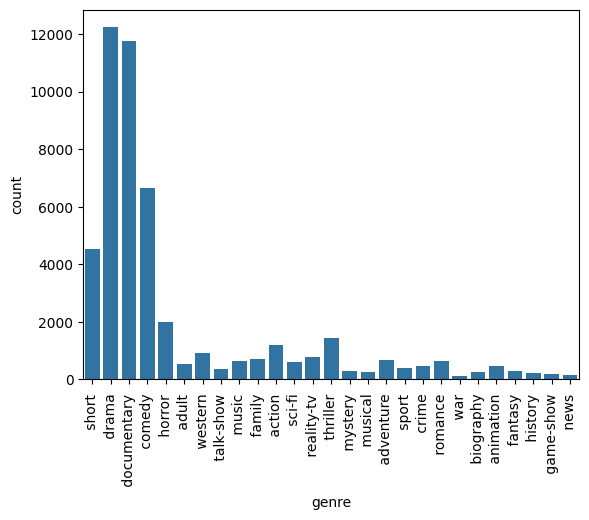

In [12]:
sns.countplot(x=y_train)
plt.xticks(rotation=90)
plt.show()

## Encode target
Following cell encodes target label to integer values in order to make it usable by the model.

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_train, y_val

(array([21,  8,  7, ...,  5,  7,  7]), array([ 5,  5,  5, ...,  8, 21,  8]))

## Train and evaluate model
Following cell creates a function which trains and evaluates given model. It prints model's accuracy, classification report and confustion matrix.

In [14]:
def train_test_model(model, X_train, y_train, X_val, y_val):
    """
    Train and evaluate the model
    Args:
      model:
      X_train: training features
      y_train: training target
      X_val: validation features
      y_val: validation target
    Returns:
      None
    """
    model.fit(X_train, y_train)
    print(model.score(X_val, y_val))
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    print(pd.DataFrame(confusion_matrix(y_val, y_pred)))

## SVC model
Train and evaluate linear SVC model.

In [15]:
svc = LinearSVC(random_state = 3)
train_test_model(svc, X_train, y_train, X_val, y_val)

0.5733037530042522
              precision    recall  f1-score   support

           0       0.39      0.34      0.37       117
           1       0.64      0.34      0.44        47
           2       0.52      0.25      0.34        89
           3       0.22      0.11      0.15        37
           4       0.00      0.00      0.00        20
           5       0.53      0.57      0.55       773
           6       0.00      0.00      0.00        42
           7       0.69      0.82      0.75      1305
           8       0.57      0.71      0.63      1335
           9       0.03      0.01      0.02        81
          10       0.38      0.09      0.14        35
          11       0.77      0.62      0.69        16
          12       0.00      0.00      0.00        25
          13       0.64      0.63      0.64       223
          14       0.61      0.42      0.50        80
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        29
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive Bayes
Train and evaluate naive bayes model.

In [16]:
NB = MultinomialNB()
train_test_model(NB, X_train, y_train, X_val, y_val)

0.5158069883527454
              precision    recall  f1-score   support

           0       0.67      0.05      0.10       117
           1       0.67      0.04      0.08        47
           2       0.83      0.06      0.11        89
           3       0.00      0.00      0.00        37
           4       0.00      0.00      0.00        20
           5       0.55      0.43      0.48       773
           6       0.00      0.00      0.00        42
           7       0.56      0.90      0.69      1305
           8       0.45      0.83      0.58      1335
           9       0.00      0.00      0.00        81
          10       0.00      0.00      0.00        35
          11       1.00      0.06      0.12        16
          12       0.00      0.00      0.00        25
          13       0.72      0.26      0.38       223
          14       1.00      0.01      0.02        80
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        29
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression
Train and evaluate logistic regression model.

In [17]:
LR = LogisticRegression(random_state=3, max_iter=500)
train_test_model(LR, X_train, y_train, X_val, y_val)

0.5853207616934738
              precision    recall  f1-score   support

           0       0.44      0.21      0.29       117
           1       0.54      0.15      0.23        47
           2       0.55      0.12      0.20        89
           3       0.40      0.05      0.10        37
           4       0.00      0.00      0.00        20
           5       0.53      0.58      0.56       773
           6       0.40      0.05      0.09        42
           7       0.66      0.87      0.75      1305
           8       0.54      0.79      0.64      1335
           9       0.12      0.01      0.02        81
          10       0.00      0.00      0.00        35
          11       1.00      0.44      0.61        16
          12       0.00      0.00      0.00        25
          13       0.68      0.58      0.63       223
          14       0.71      0.31      0.43        80
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        29
        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Load Test Data
Following cell loads test data from GitHub

In [18]:
test_data = pd.read_csv('https://raw.githubusercontent.com/PyGamer-001/Encryptix/main/Datasets/Genre%20Classification%20Dataset/test_data.txt', header=None, sep=':::', engine='python')
test_data.columns = ['id', 'title', 'description']
test_data.drop(columns=['id', 'title'], inplace=True)
test_data

,description
0,"L.R. Brane loves his life - his car, his apar..."
1,"Spain, March 1964: Quico is a very naughty ch..."
2,One year in the life of Albin and his family ...
3,"His father has died, he hasn't spoken with hi..."
4,Before he was known internationally as a mart...
...,...
54195,"Covering multiple genres, Tales of Light & Da..."
54196,As Alice and Cora Munro attempt to find their...
54197,A movie 169 years in the making. Oliver Twist...
54198,"Popular, but mysterious rock D.J Mike Mallard..."


## Clean Test Data
Following cell cleans test data's description.
> This cell takes over 9 mins to execute, thus its suggested to use the already cleaned test data without running this cell.

In [19]:
# test_data['description'] = test_data['description'].apply(clean_text)
# test_data.to_csv('clean_test_data.csv')
# test_data

## Load clean test data
Following cell loads already cleaned test data from GitHub.

In [20]:
test_data = pd.read_csv('https://raw.githubusercontent.com/PyGamer-001/Encryptix_1/main/Movie%20Genre%20Classifier/clean_test_data.csv', index_col=0)
test_data

,description,genre
0,l r brane loves life car apartment job especia...,8
1,spain march quico naughty child three belongin...,8
2,one year life albin family shepherds north tra...,7
3,father died spoken brother years serious cance...,8
4,known internationally martial arts superstar b...,8
...,...,...
54195,covering multiple genres tales light dark anth...,8
54196,alice cora munro attempt find father british o...,8
54197,movie years making oliver twist artful dodger ...,5
54198,popular mysterious rock j mike mallard askew b...,8


## Vectorize Test features
Following cell uses applies tfidf vectorization to the test features.

In [21]:
X_test = tfidf.transform(test_data['description'])
X_test

<54200x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2265093 stored elements in Compressed Sparse Row format>

## Make predictions
Following model uses the best performing model i.e. logistic regression to make predictions on test data.

In [22]:
test_data['genre'] = LR.predict(X_test)
test_data

,description,genre
0,l r brane loves life car apartment job especia...,8
1,spain march quico naughty child three belongin...,8
2,one year life albin family shepherds north tra...,7
3,father died spoken brother years serious cance...,8
4,known internationally martial arts superstar b...,8
...,...,...
54195,covering multiple genres tales light dark anth...,8
54196,alice cora munro attempt find father british o...,8
54197,movie years making oliver twist artful dodger ...,5
54198,popular mysterious rock j mike mallard askew b...,8


## Load solutions
This cell loads actual genre of test data.

In [23]:
solutions = pd.read_csv("https://raw.githubusercontent.com/PyGamer-001/Encryptix/main/Datasets/Genre%20Classification%20Dataset/test_data_solution.txt", header=None, sep=':::', engine='python')
solutions = solutions.loc[:, 2]
solutions

0            thriller 
1              comedy 
2         documentary 
3               drama 
4               drama 
             ...      
54195          horror 
54196         western 
54197           adult 
54198           drama 
54199           drama 
Name: 2, Length: 54200, dtype: object

## Encode test target
This cell encodes test target labels.

In [24]:
solutions = le.transform(solutions)
solutions

array([24,  5,  7, ...,  1,  8,  8])

## Evaluate model's predictions
This cell shows model's f1 score and accuracy over test data.

In [25]:
f1_score(solutions, test_data['genre'], average='weighted'), accuracy_score(solutions, test_data['genre'])

(0.5454831182553828, 0.5877121771217713)

## Save model
This cell saves the final model to `movie_genre_predictor.pkl`

In [26]:
with open('movie_genre_predictor.pkl', 'wb') as f:
    pickle.dump(LR, f)